# Тема: Сверточные нейронные сети

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

### 1. Oбучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете cifar-10

In [2]:
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [3]:
# разделение тренировочной и тестовой выборки
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'тренировочные примеры')
print(X_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


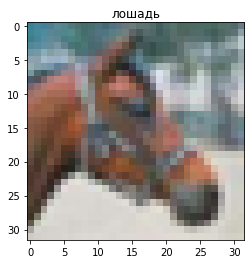

In [4]:
N = 17

plt.imshow(X_test[N])
plt.title(classes[np.argmax(y_test[N,:])])
plt.show()

In [5]:
stats = pd.DataFrame(columns=['Модель', 'Класс Train', 'Класс Test', 'Test loss', 'Test accuracy'])

batch_size = 512
epochs = 10

In [6]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()
# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [7]:
model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True)

Epoch 1/10
98/98 [==============================] - 24s 241ms/step - loss: 2.3026 - accuracy: 0.0960 - val_loss: 2.2948 - val_accuracy: 0.1506
Epoch 2/10
98/98 [==============================] - 23s 238ms/step - loss: 2.2914 - accuracy: 0.1635 - val_loss: 2.2763 - val_accuracy: 0.1627
Epoch 3/10
98/98 [==============================] - 24s 247ms/step - loss: 2.2642 - accuracy: 0.1853 - val_loss: 2.2019 - val_accuracy: 0.2100
Epoch 4/10
98/98 [==============================] - 24s 248ms/step - loss: 2.1591 - accuracy: 0.2262 - val_loss: 2.1131 - val_accuracy: 0.2267
Epoch 5/10
98/98 [==============================] - 24s 244ms/step - loss: 2.0574 - accuracy: 0.2545 - val_loss: 1.9698 - val_accuracy: 0.3080
Epoch 6/10
98/98 [==============================] - 24s 241ms/step - loss: 1.9922 - accuracy: 0.2898 - val_loss: 1.9213 - val_accuracy: 0.3161
Epoch 7/10
98/98 [==============================] - 24s 248ms/step - loss: 1.9418 - accuracy: 0.3086 - val_loss: 1.8919 - val_accuracy: 0.3170

In [8]:
# проверка работы обученной модели
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

y_p = model.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )

new_row = {'Модель':'CNN базовая', 'Класс Train':classes[y_t[0]], 'Класс Test': classes[y_i[0]], \
           'Test loss':round(scores[0], 4), 'Test accuracy':round(scores[1], 4)}

stats = stats.append(new_row, ignore_index=True)

313/313 [==============================] - 1s 4ms/step - loss: 1.7586 - accuracy: 0.3811
Test loss: 1.7585691213607788
Test accuracy: 0.38109999895095825


In [9]:
stats

,Модель,Класс Train,Класс Test,Test loss,Test accuracy
0,CNN базовая,лошадь,олень,1.7586,0.3811


### 2. Оценить рост точности при увеличении ширины сети (больше фильтров)

In [10]:
# конфигурирование слоев нейросети
model1 = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model1.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# полносвязные слои нейронной сети
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dense(10, activation='softmax'))

model1.summary()
# компиляция модели
model1.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)       36992     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)             

In [11]:
model1.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True)

Epoch 1/10
98/98 [==============================] - 36s 366ms/step - loss: 2.2986 - accuracy: 0.1220 - val_loss: 2.2851 - val_accuracy: 0.1266
Epoch 2/10
98/98 [==============================] - 36s 367ms/step - loss: 2.2773 - accuracy: 0.1364 - val_loss: 2.2387 - val_accuracy: 0.2026
Epoch 3/10
98/98 [==============================] - 36s 367ms/step - loss: 2.2072 - accuracy: 0.2184 - val_loss: 2.0643 - val_accuracy: 0.2669
Epoch 4/10
98/98 [==============================] - 36s 365ms/step - loss: 2.0660 - accuracy: 0.2555 - val_loss: 1.9714 - val_accuracy: 0.3066
Epoch 5/10
98/98 [==============================] - 36s 366ms/step - loss: 1.9861 - accuracy: 0.2949 - val_loss: 1.9262 - val_accuracy: 0.3234
Epoch 6/10
98/98 [==============================] - 36s 362ms/step - loss: 1.9419 - accuracy: 0.3116 - val_loss: 1.8829 - val_accuracy: 0.3351
Epoch 7/10
98/98 [==============================] - 36s 363ms/step - loss: 1.8990 - accuracy: 0.3266 - val_loss: 1.8726 - val_accuracy: 0.3439

In [12]:
# проверка работы обученной модели
scores = model1.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

y_p = model1.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )

new_row = {'Модель':'CNN c увеличением каналов', 'Класс Train':classes[y_t[0]], 'Класс Test': classes[y_i[0]], \
           'Test loss':round(scores[0], 4), 'Test accuracy':round(scores[1], 4)}

stats = stats.append(new_row, ignore_index=True)

313/313 [==============================] - 2s 6ms/step - loss: 1.7607 - accuracy: 0.3789
Test loss: 1.7606685161590576
Test accuracy: 0.3788999915122986


In [13]:
stats

,Модель,Класс Train,Класс Test,Test loss,Test accuracy
0,CNN базовая,лошадь,олень,1.7586,0.3811
1,CNN c увеличением каналов,лошадь,кот,1.7607,0.3789


### 3. Оценить рост точности при увеличении глубины сети (больше слоев)

In [14]:
# конфигурирование слоев нейросети
model2 = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# полносвязные слои нейронной сети
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(10, activation='softmax'))

model2.summary()
# компиляция модели
model2.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 6, 128)        

In [15]:
model2.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True)

Epoch 1/10
98/98 [==============================] - 27s 272ms/step - loss: 2.3014 - accuracy: 0.1327 - val_loss: 2.2975 - val_accuracy: 0.1308
Epoch 2/10
98/98 [==============================] - 26s 269ms/step - loss: 2.2959 - accuracy: 0.1211 - val_loss: 2.2907 - val_accuracy: 0.1026
Epoch 3/10
98/98 [==============================] - 26s 270ms/step - loss: 2.2883 - accuracy: 0.1024 - val_loss: 2.2781 - val_accuracy: 0.1060
Epoch 4/10
98/98 [==============================] - 26s 269ms/step - loss: 2.2724 - accuracy: 0.1163 - val_loss: 2.2485 - val_accuracy: 0.1451
Epoch 5/10
98/98 [==============================] - 26s 270ms/step - loss: 2.2330 - accuracy: 0.1643 - val_loss: 2.1610 - val_accuracy: 0.2096
Epoch 6/10
98/98 [==============================] - 26s 270ms/step - loss: 2.1377 - accuracy: 0.2194 - val_loss: 2.0506 - val_accuracy: 0.2670
Epoch 7/10
98/98 [==============================] - 26s 270ms/step - loss: 2.0797 - accuracy: 0.2455 - val_loss: 2.1462 - val_accuracy: 0.2110

In [16]:
# проверка работы обученной модели
scores = model2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

y_p = model2.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )

new_row = {'Модель':'CNN c увеличением слоев', 'Класс Train':classes[y_t[0]], 'Класс Test': classes[y_i[0]], \
           'Test loss':round(scores[0], 4), 'Test accuracy':round(scores[1], 4)}

stats = stats.append(new_row, ignore_index=True)

313/313 [==============================] - 1s 5ms/step - loss: 1.8888 - accuracy: 0.3125
Test loss: 1.8888089656829834
Test accuracy: 0.3125


In [17]:
stats

,Модель,Класс Train,Класс Test,Test loss,Test accuracy
0,CNN базовая,лошадь,олень,1.7586,0.3811
1,CNN c увеличением каналов,лошадь,кот,1.7607,0.3789
2,CNN c увеличением слоев,лошадь,лошадь,1.8888,0.3125


### 4.\* сравнить с точностью полносвязной сети для этой выборки

In [18]:
inputs = Input(shape=(32, 32, 3))
x = Flatten()(inputs)
x_1 = Dense(512, activation='relu')(x)
x_2 = Dense(256, activation='relu')(x_1)
x_3 = Dense(128, activation='relu')(x_2)
x_4 = Dense(32, activation='relu')(x_3)
outputs = Dense(10)(x_4)
    
model3 = Model(inputs, outputs)
model3.summary()

model3.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330   

In [19]:
model3.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True)

Epoch 1/10
98/98 [==============================] - 1s 12ms/step - loss: 8.6334 - accuracy: 0.1015 - val_loss: 11.2827 - val_accuracy: 0.1000
Epoch 2/10
98/98 [==============================] - 1s 11ms/step - loss: 11.2940 - accuracy: 0.0997 - val_loss: 11.2827 - val_accuracy: 0.1000
Epoch 3/10
98/98 [==============================] - 1s 11ms/step - loss: 11.2885 - accuracy: 0.1009 - val_loss: 11.2827 - val_accuracy: 0.1000
Epoch 4/10
98/98 [==============================] - 1s 11ms/step - loss: 11.3343 - accuracy: 0.0987 - val_loss: 11.2827 - val_accuracy: 0.1000
Epoch 5/10
98/98 [==============================] - 1s 11ms/step - loss: 11.2782 - accuracy: 0.0983 - val_loss: 11.2827 - val_accuracy: 0.1000
Epoch 6/10
98/98 [==============================] - 1s 11ms/step - loss: 11.2940 - accuracy: 0.0993 - val_loss: 11.2827 - val_accuracy: 0.1000
Epoch 7/10
98/98 [==============================] - 1s 11ms/step - loss: 11.3170 - accuracy: 0.0984 - val_loss: 11.2827 - val_accuracy: 0.1000


In [20]:
# проверка работы обученной модели
scores = model3.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

y_p = model3.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )

new_row = {'Модель':'Полносвязная', 'Класс Train':classes[y_t[0]], 'Класс Test': classes[y_i[0]], \
           'Test loss':round(scores[0], 4), 'Test accuracy':round(scores[1], 4)}

stats = stats.append(new_row, ignore_index=True)

313/313 [==============================] - 0s 909us/step - loss: 11.2827 - accuracy: 0.1000
Test loss: 11.282669067382812
Test accuracy: 0.10000000149011612


In [21]:
stats

,Модель,Класс Train,Класс Test,Test loss,Test accuracy
0,CNN базовая,лошадь,олень,1.7586,0.3811
1,CNN c увеличением каналов,лошадь,кот,1.7607,0.3789
2,CNN c увеличением слоев,лошадь,лошадь,1.8888,0.3125
3,Полносвязная,лошадь,собака,11.2827,0.1000


**Вывод:**
- самый лучший результат у модели CNN с большим количеством слоев. 